In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from util.custom_loss.custom_loss import mse_loss, sparsity_loss, dirichlet_loss
from util.ImageFolderWithPaths import ImageFolderWithPaths
from util.random_patient import random_split

In [2]:
print(torch.cuda.device_count())
torch.cuda.empty_cache()
torch.cuda.mem_get_info()

1


(16790978560, 17059545088)

In [3]:
BATCH_SIZE = 4

# setting the correct device to train on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

MAIN_PATH = '/home/u6/njcrutchfield/torch/NN/pill_data/pillQC-main/images' # images are 225 x 225 x 3
# PATH1 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/A'
# PATH2 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/S'

tensor_transform = transforms.ToTensor()
horizontal_flip = transforms.RandomHorizontalFlip(p=1)

# Dataset of both normal and horizontal flipped images
dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) + datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
                                                                                                                     tensor_transform,
                                                                                                                     horizontal_flip
                                                                                                                   ]))


In [4]:
SPLIT = [528, 66, 66]
train_set, _, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [5]:
class Encoder(nn.Module):
    def __init__(self, in_channel=3, out_channel=3500, activation=nn.GELU()):
        super().__init__()
        # The input size is 3*225*225
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.encoder = nn.Sequential(
                                nn.Conv2d(in_channels=in_channel,out_channels=16,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(16), activation,
                                nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(32), activation,
                                nn.Conv2d(in_channels=32,out_channels=32,kernel_size=2,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(32), activation,
                                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(64), activation,
                                nn.Conv2d(in_channels=64,out_channels=64,kernel_size=2,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(64), activation,
                                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(128), activation,
                                nn.Conv2d(in_channels=128,out_channels=128,kernel_size=2,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(128), activation,
                                nn.Conv2d(in_channels=128,out_channels=320,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(320), activation,
                                nn.Conv2d(in_channels=320,out_channels=240,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(240), activation,
                                nn.Conv2d(in_channels=240,out_channels=150,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(150), activation,
                                nn.Conv2d(in_channels=150,out_channels=80,kernel_size=3,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(80), activation,
                                nn.Conv2d(in_channels=80,out_channels=40,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(40), activation,
                                nn.Conv2d(in_channels=40,out_channels=15,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(15), activation,
                                nn.Flatten(),
                                nn.Linear(in_features=15*15*15, out_features=out_channel),
                                nn.Softmax(dim=1))
        
    def forward(self, x):
        x = x.view(-1, self.in_channel, 225, 225)
        prob = self.encoder(x)
        return prob


class Decoder(nn.Module):
    def __init__(self, in_channel=3, out_channel=1600, activation=nn.GELU()):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel

        self.mlp = nn.Sequential(nn.Linear(in_features=out_channel, out_features=15*15*15, bias=False),
                                 nn.BatchNorm1d(15*15*15),activation,
                                 nn.Unflatten(1, (15, 15, 15)))
        self.decoder = nn.Sequential(
                                nn.ConvTranspose2d(in_channels=15,out_channels=40,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(40), activation,
                                nn.ConvTranspose2d(in_channels=40,out_channels=80,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(80), activation,
                                nn.ConvTranspose2d(in_channels=80,out_channels=150,kernel_size=3,stride=2,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(150), activation,
                                nn.ConvTranspose2d(in_channels=150,out_channels=240,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(240), activation,
                                nn.ConvTranspose2d(in_channels=240,out_channels=320,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(320), activation,
                                nn.ConvTranspose2d(in_channels=320,out_channels=128,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(128), activation,
                                nn.ConvTranspose2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(128), activation,
                                nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(64), activation,
                                nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=3,stride=2,padding=2,output_padding=0,bias=False),
                                nn.BatchNorm2d(64), activation,
                                nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(32), activation,
                                nn.ConvTranspose2d(in_channels=32,out_channels=32,kernel_size=3,stride=2,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(32), activation,
                                nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=3,stride=1,padding=0,output_padding=0,bias=False),
                                nn.BatchNorm2d(16), activation,
                                nn.ConvTranspose2d(in_channels=16, out_channels=in_channel, kernel_size=3, stride=1, padding=0, output_padding=0),
                                nn.Sigmoid())
    
    def forward(self, x):
        x = x.view(-1, self.out_channel)
        temp = self.mlp(x)
        temp = temp.view(-1,15,15,15)
        output = self.decoder(temp)
        return output

In [6]:
enc_out = 64
encoder = Encoder(out_channel = enc_out)

rand_mat_dim = 32
decoder = Decoder(out_channel = rand_mat_dim)

In [7]:
rand_mat = torch.randn(rand_mat_dim, enc_out, requires_grad=False, device='cuda' if torch.cuda.is_available() else 'cpu')
rand_mat = rand_mat.div(torch.norm(rand_mat, dim = 0))

In [8]:
rand_mat.size()

torch.Size([32, 64])

In [9]:
with open('progress.txt', 'w') as file:
    file.write(f"{Encoder=}\n\n{Decoder=}\n\nTraining:\n")

In [10]:
EPOCHS = 20
loss_weights = [1, 0.001, 0] # [1,0,0]
early_stop_depth = 10
verbose = 1

LR = 0.00005 # [0.00005]
WEIGHT_DECAY = 0.01 # [0.01]

In [11]:
class AE(torch.nn.Module):
    def __init__(self, encoder, decoder, rand_mat):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.rand_mat = rand_mat
        
    def forward(self, x):
        enc = encoder(x)
        all_dps = []
        for batch in enc:
            all_dps.append(torch.mv(self.rand_mat, batch))
        Dp = torch.stack(all_dps)
        
        p_vec = F.softmax(Dp, dim = 1)
        
        
        
        dec = decoder(p_vec)
        return dec, p_vec

In [12]:
ae = AE(encoder, decoder, rand_mat).to(device)

In [13]:
optimizer = torch.optim.Adam(ae.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)

In [14]:
torch.autograd.set_detect_anomaly(True)

encoder.to(device)
decoder.to(device)

loss_arr = []

for epoch in range(EPOCHS):
    loss = 0
    for img, _ in train_loader:
        encoder.train()
        decoder.train()
        
        img = img.to(device)
        
        dec, p_vec = ae(img)
        
        loss =  (loss_weights[0] * mse_loss(dec, img) +
                loss_weights[1] * sparsity_loss(p_vec) +
                loss_weights[2] * dirichlet_loss(p_vec))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    loss_arr.append(loss.item())
    text = f'\nEpoch: {epoch + 1} | Loss: {loss.item():.4f}'
    print(text, end='\n'*2)
    with open('progress.txt', 'a') as file:
        file.write(f"{text}\n\n")
        
        


/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/utils/_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return func(*args, **kwargs)
/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Epoch: 1 | Loss: 0.0476


Epoch: 2 | Loss: 0.0283


Epoch: 3 | Loss: 0.0249


Epoch: 4 | Loss: 0.0210


Epoch: 5 | Loss: 0.0224


Epoch: 6 | Loss: 0.0188


Epoch: 7 | Loss: 0.0206


Epoch: 8 | Loss: 0.0179


Epoch: 9 | Loss: 0.0202


Epoch: 10 | Loss: 0.0208


Epoch: 11 | Loss: 0.0187


Epoch: 12 | Loss: 0.0179


Epoch: 13 | Loss: 0.0198


Epoch: 14 | Loss: 0.0206


Epoch: 15 | Loss: 0.0230


Epoch: 16 | Loss: 0.0178


Epoch: 17 | Loss: 0.0201


Epoch: 18 | Loss: 0.0176


Epoch: 19 | Loss: 0.0190


Epoch: 20 | Loss: 0.0186



In [16]:
torch.save(ae.rand_mat, f'./models/ae_model_rand_mat.pth')
torch.save(ae.state_dict(), f'./models/ae_model_gs.pth')

with open('progress.txt', 'a') as file:
    file.write(f"Saved\n\n")
print("done")

done


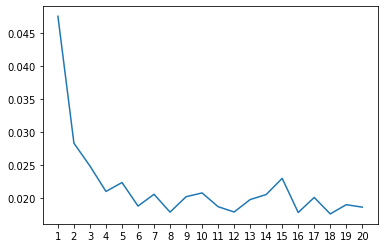

In [17]:
ep = [x+1 for x in range(len(loss_arr))]
plt.plot(ep, loss_arr)
plt.xticks(ep)
plt.show()

In [18]:
print(torch.cuda.mem_get_info())
torch.cuda.empty_cache()

(16044392448, 17059545088)


In [19]:
torch.set_default_device('cuda')

MAIN_PATH = '/home/u6/njcrutchfield/torch/NN/pill_data/pillQC-main/images' # images are 225 x 225 x 3
# PATH1 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/A'
# PATH2 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/S'

tensor_transform = transforms.ToTensor()
horizontal_flip = transforms.RandomHorizontalFlip(p=1)


# Dataset of both normal and horizontal flipped images
dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) + datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
                                                                                                                      tensor_transform,
                                                                                                                      horizontal_flip
                                                                                                                    ]))
SPLIT = [528, 66, 66]
_, val_set, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

val_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = 1,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [21]:
rand_mat

tensor([[-0.1202,  0.4678,  0.0759,  ..., -0.2534, -0.1831,  0.0521],
        [-0.0344, -0.3074, -0.2837,  ...,  0.4001,  0.0621, -0.0984],
        [ 0.0501,  0.0201, -0.1662,  ..., -0.3136,  0.1016,  0.0689],
        ...,
        [ 0.1256, -0.2733, -0.1673,  ..., -0.0563,  0.1551, -0.0572],
        [ 0.0333, -0.1406,  0.0992,  ...,  0.2730,  0.1761, -0.1906],
        [-0.2211,  0.2813,  0.1520,  ..., -0.1740,  0.0286,  0.4958]],
       device='cuda:0')

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(out_channel = enc_out)
decoder = Decoder(out_channel = rand_mat_dim)
temp = torch.randn(rand_mat_dim, enc_out, requires_grad=False, device='cuda' if torch.cuda.is_available() else 'cpu')
temp = rand_mat.div(torch.norm(rand_mat, dim = 0))

model = AE(encoder, decoder, rand_mat=temp).to(device)
model.load_state_dict(torch.load('./models/ae_model_gs.pth'))
model.rand_mat = torch.load('./models/ae_model_rand_mat.pth')

# setting the encoder and decoder for visualization
encoder = model.encoder
decoder = model.decoder
rand_mat = model.rand_mat

In [48]:
# input and output arrays
auto_encoder_output = []
encoded_imgs_arr = []
decoded_imgs_arr = []


mse_running_total = 0
count = 0

torch.set_default_device('cuda')

for (inp, _) in val_loader:
    model.eval()
    with torch.no_grad():
        inp = inp.to(device)
        oup, p_vec = model(inp)
        encoded_imgs_arr.append(p_vec)
        
        mse_running_total += np.square(inp.cpu().numpy() - oup.cpu().numpy()).mean()

                
        if count % 1 == 0:
            auto_encoder_output.append((inp, oup))
        count += 1



In [49]:
mse_running_total/len(val_loader)

0.01710768439013257

In [50]:
import matplotlib.pyplot as plt

In [51]:
x = encoded_imgs_arr[0]
y = encoded_imgs_arr[10]

In [70]:
x[0]

tensor([0.0321, 0.0313, 0.0317, 0.0311, 0.0318, 0.0318, 0.0308, 0.0310, 0.0317,
        0.0317, 0.0303, 0.0314, 0.0313, 0.0314, 0.0318, 0.0323, 0.0304, 0.0315,
        0.0311, 0.0310, 0.0303, 0.0314, 0.0310, 0.0324, 0.0308, 0.0310, 0.0306,
        0.0307, 0.0307, 0.0308, 0.0316, 0.0313], device='cuda:0')

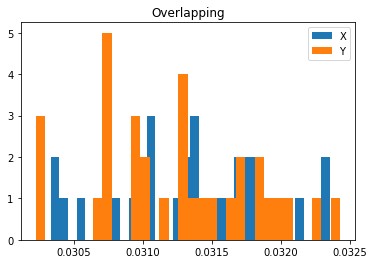

In [72]:
plt.hist(x[0].cpu().numpy(), bins=len(x[0]), label='X');
plt.hist(y[0].cpu().numpy(), bins=len(y[0]), label='Y');
  
plt.legend(loc='upper right') 
plt.title('Overlapping') 
plt.show()

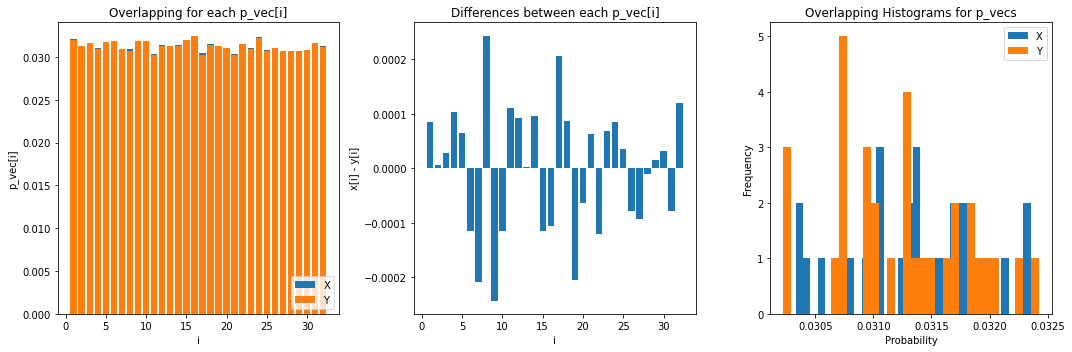

In [110]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.bar(arr, x[0].cpu().numpy(), label = 'X');
plt.bar(arr, y[0].cpu().numpy(), label = 'Y');

plt.legend(loc='lower right') 
plt.xlabel('i')
plt.ylabel('p_vec[i]')
plt.title('Overlapping for each p_vec[i]') 

plt.subplot(1,3,2)
plt.bar(arr, (x[0]-y[0]).cpu().numpy());
plt.xlabel('i')
plt.ylabel('x[i] - y[i]')
plt.title('Differences between each p_vec[i]') 

plt.subplot(1,3,3)
plt.hist(x[0].cpu().numpy(), bins=len(x[0]), label='X');
plt.hist(y[0].cpu().numpy(), bins=len(y[0]), label='Y');
plt.xlabel('Probability')
plt.ylabel('Frequency')
  
plt.legend(loc='upper right') 
plt.title('Overlapping Histograms for p_vecs') 

plt.tight_layout()
plt.show()

In [57]:
import random
mse_running_total = 0
arr = []
for i in range(len(encoded_imgs_arr)):
    num = np.square(encoded_imgs_arr[i].cpu().numpy() - encoded_imgs_arr[random.randint(0,len(encoded_imgs_arr)-1)].cpu().numpy()).mean()
    arr.append(num)
    mse_running_total += num
print(f'{mse_running_total=}')

mse_running_total=1.7539306728098225e-05


In [58]:
mse_running_total = 0
for (img, _) in val_loader:
    model.eval()
    with torch.no_grad():

        inp = img.to(device)
        decoded, _ = model(inp)
        mse_running_total += np.square(inp.cpu().numpy() - decoded.cpu().numpy()).mean()
        break

In [59]:
print(inp.size())

torch.Size([1, 3, 225, 225])


torch.Size([3, 225, 225])
0.01770913600921631


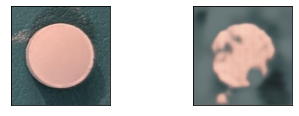

In [60]:
cols = 2
amt = 2
ax = plt.subplot(cols, amt, 1)
img = inp.squeeze()
img = img.detach().cpu().numpy()
plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(cols,amt, 2)
recon = decoded.squeeze()
print(recon.shape)
recon = recon.detach().cpu().numpy()
plt.imshow(np.transpose(recon, (1,2,0)))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

print(mse_running_total)

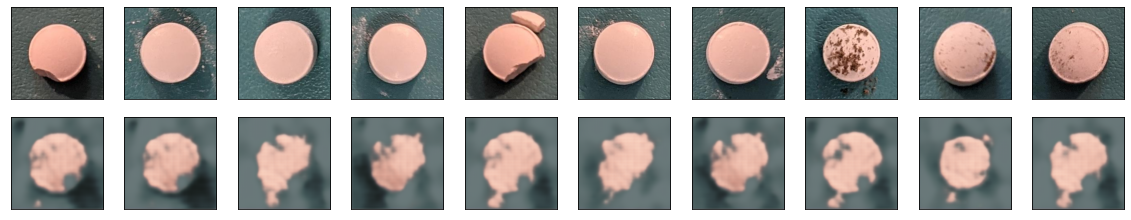

In [62]:
# Validation Set Images
amt = 10
cols = 10
plt.figure(figsize=(20,20))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = auto_encoder_output[k][0].squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # recon image
    ax = plt.subplot(cols,amt, k+1+amt)
    recon = auto_encoder_output[k+10][1].squeeze()
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [63]:
# Training between epochs
amt = len(outputs)
cols = 10
plt.figure(figsize=(20,20))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = outputs[k][0][0].squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # recon image
    ax = plt.subplot(cols,amt, k+1+amt)
    recon = outputs[k][1][0].squeeze()
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

NameError: name 'outputs' is not defined

In [64]:
for i in range(len(auto_encoder_output)-1):
    recon1, recon2 = auto_encoder_output[i][1], auto_encoder_output[i+1][1]
    print(torch.sum(recon1 - recon2))

tensor(-8304.5342, device='cuda:0')
tensor(-953.9186, device='cuda:0')
tensor(-851.8379, device='cuda:0')
tensor(10389.8857, device='cuda:0')
tensor(-7583.1187, device='cuda:0')
tensor(2326.4429, device='cuda:0')
tensor(2639.7244, device='cuda:0')
tensor(-1808.6356, device='cuda:0')
tensor(4179.6685, device='cuda:0')
tensor(-1603.8083, device='cuda:0')
tensor(793.7278, device='cuda:0')
tensor(-6556.2656, device='cuda:0')
tensor(8105.6074, device='cuda:0')
tensor(-9594.3633, device='cuda:0')
tensor(419.2616, device='cuda:0')
tensor(7957.0586, device='cuda:0')
tensor(-6486.1455, device='cuda:0')
tensor(85.7299, device='cuda:0')
tensor(-1203.1636, device='cuda:0')
tensor(6404.4326, device='cuda:0')
tensor(-3743.2527, device='cuda:0')
tensor(-4778.0234, device='cuda:0')
tensor(560.2227, device='cuda:0')
tensor(9003.1729, device='cuda:0')
tensor(-3221.0776, device='cuda:0')
tensor(859.5975, device='cuda:0')
tensor(-3510.7393, device='cuda:0')
tensor(1357.4215, device='cuda:0')
tensor(4157.6

tensor(-6838.3652, device='cuda:0')
tensor(8773.4717, device='cuda:0')
tensor(-4816.9839, device='cuda:0')
tensor(1969.7295, device='cuda:0')
tensor(-5554.9297, device='cuda:0')
tensor(-545.3138, device='cuda:0')
tensor(5626.8037, device='cuda:0')
tensor(-561.2078, device='cuda:0')
tensor(4562.9316, device='cuda:0')
tensor(-3869.7529, device='cuda:0')
tensor(2681.3792, device='cuda:0')
tensor(-4727.1978, device='cuda:0')
tensor(1440.1604, device='cuda:0')
tensor(6942.4663, device='cuda:0')
tensor(-4518.4673, device='cuda:0')
tensor(-2055.4250, device='cuda:0')
tensor(3319.1367, device='cuda:0')
tensor(-1504.1200, device='cuda:0')
tensor(-1583.1185, device='cuda:0')
tensor(5391.3833, device='cuda:0')
tensor(-2755.5903, device='cuda:0')
tensor(-5710.5547, device='cuda:0')
tensor(-747.9966, device='cuda:0')
tensor(7854.4097, device='cuda:0')
tensor(-7921.3154, device='cuda:0')
tensor(1938.6049, device='cuda:0')
tensor(2539.9739, device='cuda:0')
tensor(130.4534, device='cuda:0')
tensor(-6